In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Set the option to prevent the FutureWarning
pd.set_option('future.no_silent_downcasting', True)
import datetime as dt
import os
from dtype_dictionaries import *

### Import routine

In [3]:
# Name of the folder containing subfolders with csv files
folder_name = 'mapped_realtime_data'
list_of_subfolders = os.listdir(folder_name)
list_of_subfolders_paths = [os.path.join(folder_name, subfolder) for subfolder in list_of_subfolders]
df_list = []

# Start a loop across all subfolders
for subfolder_path in list_of_subfolders_paths[0:1]:
    print(f'reading subfolder: {subfolder_path}')
    # List all files in the subfolder
    list_of_files = os.listdir(subfolder_path)
    list_of_files_paths = [os.path.join(subfolder_path, file) for file in list_of_files]
    # Start a loop across all files in the subfolder
    for file_path in list_of_files_paths:
        # Print file path
        #print(f'reading file: {file_path}')
        # Read the csv file
        df = pd.read_csv(file_path, sep=',', header=0, low_memory=False, dtype=layover_dtype_map)
        # Convert the 'timestamp' column to datetime
        df['service_date'] = pd.to_datetime(df['service_date'], format='%Y-%m-%d')
        df['scheduled'] = pd.to_datetime(df['scheduled'])
        df['actual'] = pd.to_datetime(df['actual'])                                
        #df['scheduled'] = pd.to_datetime(df['scheduled'], format='ISO8601', utc=True).dt.time
        #df['actual'] = pd.to_datetime(df['actual'], format='ISO8601', utc=True).dt.time
        # Uncomment these two lines if you wish to have block_ids formatted without square brackets
        df['block_id'] = df['block_id'].str.extract(r"\['(.*?)'\]")
        df['block_id'] = df['block_id'].astype('category')
        df_list.append(df)

reading subfolder: mapped_realtime_data\mapped_realtime_data20211219_20220312


In [4]:
test = pd.concat(df_list, axis=0, ignore_index=True)
# Sort data by service_date, block_id and half_trip_id
test = test.sort_values(by=['route_id','service_date', 'block_id', 'half_trip_id'])

In [5]:
# Group by service_date and block_id
grouped = test.groupby(['route_id','service_date', 'block_id'], observed=True)
# Calculate theoretical and actual layover times using diff()
test['theoretical_layover'] = grouped['scheduled'].diff().dt.total_seconds() / 60
test['actual_layover'] = grouped['actual'].diff().dt.total_seconds() / 60
# Replace the first row of each group with null timedelta
test.loc[grouped.head(1).index, ['theoretical_layover', 'actual_layover']] = 0
# Replace negative values with their 24h complement
test.loc[test.theoretical_layover < 0, 'theoretical_layover'] = 1440 + test.theoretical_layover
test.loc[test.actual_layover < 0, 'actual_layover'] = 1440 + test.actual_layover
#test.loc[test.point_type != 'Endpoint', ['theoretical_layover', 'actual_layover']] = np.nan

In [ ]:
# Group again by service_date and block_id, and calculate the mean layover time
mask = (test.theoretical_layover < 60) & (test.actual_layover < 60)
grouped = test.loc[mask].groupby(['service_date'], observed=True)
layover_means = grouped[['theoretical_layover', 'actual_layover']].mean()
print(type(layover_means))
# Compute the overall mean layovers
overall_means = layover_means.mean()

In [ ]:
plot_df = test.loc[(test.point_type == 'Startpoint')&(test.actual_layover<60), ['service_date', 'theoretical_layover', 'actual_layover']]
# Build a scatter plot with service_date on the x axis and scheduled and actual layover times on the y axis
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the data
ax.plot(layover_means.index, layover_means['theoretical_layover'], label='Scheduled Layover', color='#BFD430')
ax.plot(layover_means.index, layover_means['actual_layover'], label='Actual Layover', color='#248ED3')
# Plot also the overall means as two horizontal lines
ax.axhline(y=overall_means['theoretical_layover'], color='#BFD430', linestyle='--', label='Mean (Scheduled)')
ax.axhline(y=overall_means['actual_layover'], color='#248ED3', linestyle='--', label='Mean (Actual)')
# Set the labels
ax.set_xlabel('Service Date', fontsize=20)
ax.set_ylabel('Layover Time (minutes)', fontsize=20)
# Set the title
ax.set_title('Scheduled and Actual Layover Times', fontsize=20)
# Set the legend
ax.legend(fontsize=20)
# Increase fontsize of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Rotate the x axis labels
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [29]:
# Group again by service_date and stop_id, and calculate the mean, min and max layover time
mask = (test.theoretical_layover < 60) & (test.actual_layover < 60) & (test.theoretical_layover > 0) & (test.actual_layover > 0)
grouped = test.loc[mask].groupby(['stop_id'], observed=True).agg({'actual_layover': ['count', 'mean', 'min', 'max']})
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
top10 =grouped.sort_values(by='actual_layover_mean', ascending=False).head(10)
top10

,actual_layover_count,actual_layover_mean,actual_layover_min,actual_layover_max
stop_id,,,,
9525,2410,44.702420,21.033333,59.866667
142,2599,44.574689,23.550000,59.983333
7486,47,41.361702,30.683333,57.283333
7542,1,41.266667,41.266667,41.266667
1123,3875,41.092443,0.283333,59.950000
6842,51,40.548366,22.816667,45.966667
926,90,40.297963,32.566667,51.016667
7223,293,39.681001,24.066667,59.850000
1332,138,39.172585,28.416667,53.700000


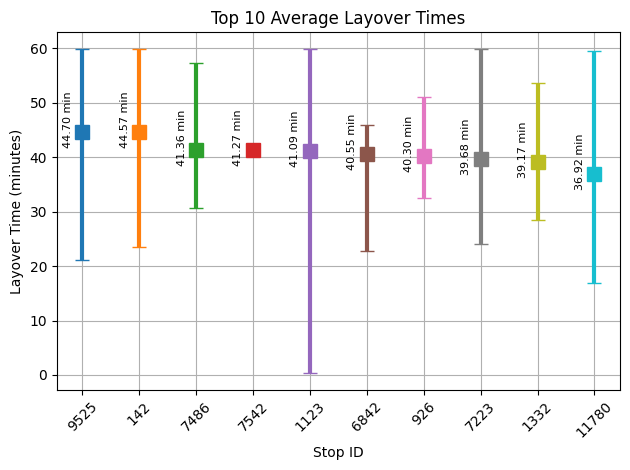

In [28]:
for idx in top10.index:
    plt.errorbar(idx, top10.actual_layover_mean[idx], 
                  yerr=[[top10.actual_layover_mean[idx] - top10.actual_layover_min[idx]], 
                        [top10.actual_layover_max[idx] - top10.actual_layover_mean[idx]]], fmt='s', elinewidth=3, capsize=5, ms=10)

    # Add annotation
    plt.annotate(f'{top10.actual_layover_mean[idx]:.2f} min', xy=(idx, top10.actual_layover_mean[idx]), xytext=(-7, -10), textcoords='offset points', ha='right', rotation='vertical', fontsize=8)

plt.xlabel('Stop ID')
plt.ylabel('Layover Time (minutes)')
plt.title('Top 10 Average Layover Times')
plt.grid(True)
plt.xticks(top10.index, rotation=45)
plt.tight_layout()
plt.show()

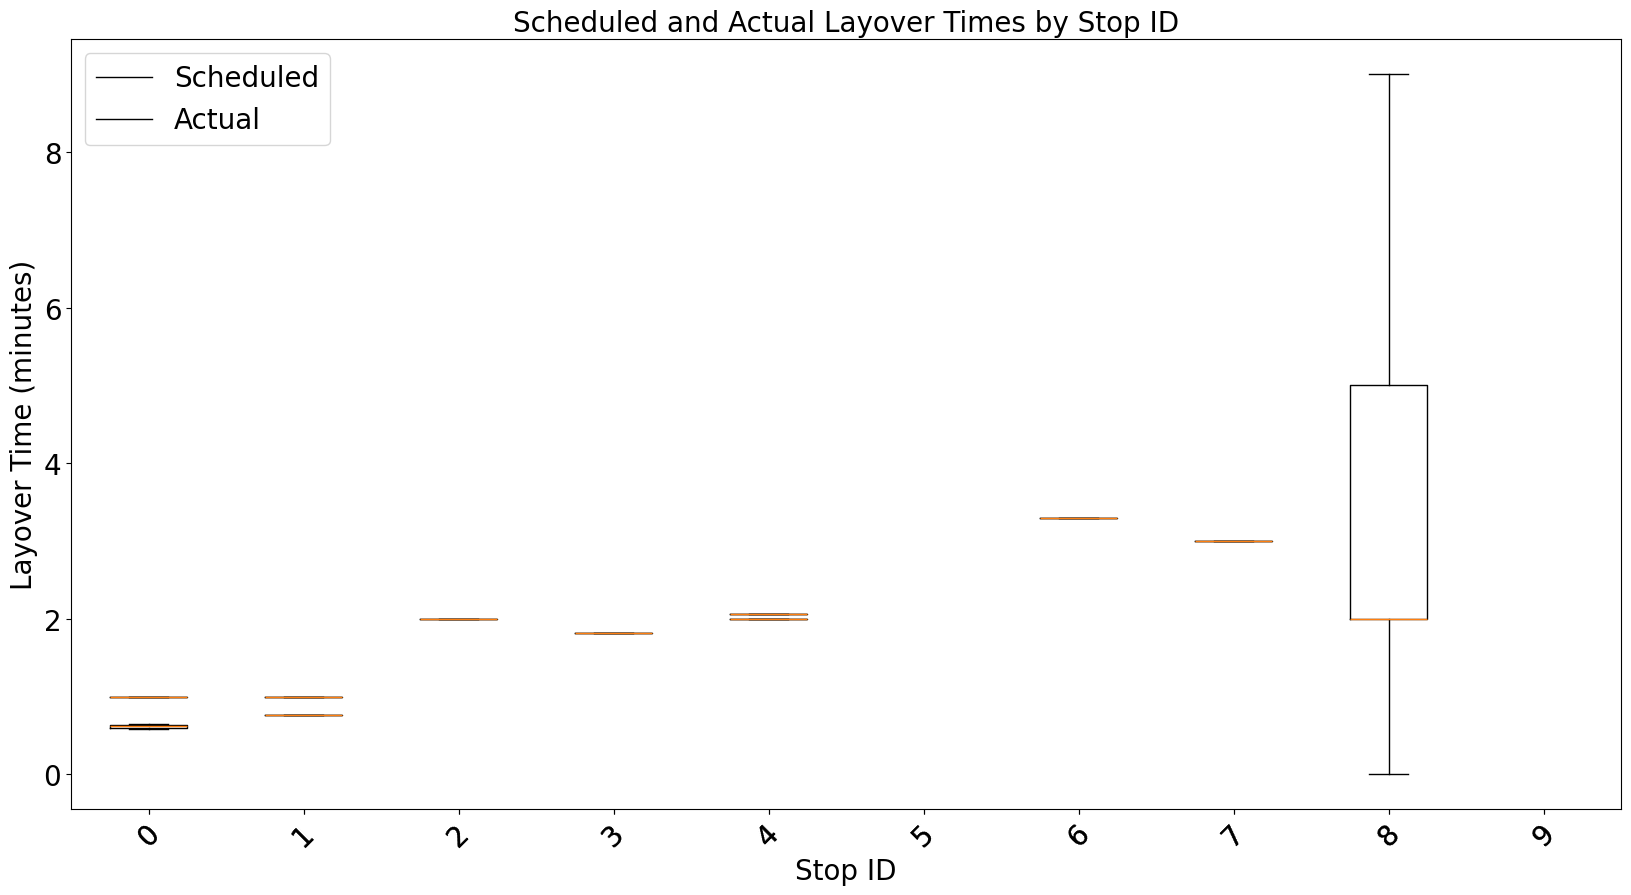

In [11]:
# Build a box plot with stop_id on the x axis and scheduled and actual layover times on the y axis. Plot only the first ten stop_ids by mean layover time
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the data
ax.boxplot([test.loc[test.stop_id == stop_id, 'theoretical_layover'] for stop_id in grouped.sort_values(by='theoretical_layover_mean').head(10)['stop_id']], positions=range(10), showfliers=False)
ax.boxplot([test.loc[test.stop_id == stop_id, 'actual_layover'] for stop_id in grouped.sort_values(by='actual_layover_mean').head(10)['stop_id']], positions=range(10), showfliers=False)
# Set the labels
ax.set_xlabel('Stop ID', fontsize=20)
ax.set_ylabel('Layover Time (minutes)', fontsize=20)
# Set the title
ax.set_title('Scheduled and Actual Layover Times by Stop ID', fontsize=20)
# Set the legend
ax.legend(['Scheduled', 'Actual'], fontsize=20)
# Increase fontsize of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# Rotate the x axis labels
plt.xticks(rotation=45)
# Show the plot
plt.show()